In [247]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

np.set_printoptions(precision=3, suppress=True)
np.set_printoptions(legacy='1.13')

beta, alpha = 7,1
n_consumer = 10 #number of consumer in market 
sigma_b, sigma_a = 0.2, 0.2 #chosen sigma 

#import previous simulated datasets 
dataset = pd.read_csv("multi_market_data.csv")
chosen_market = 0

## 🧪 Practice 4: Simulating Random Coefficients (Consumer Heterogeneity)

### 🎯 Goal
Simulate individual-level taste variation by drawing random coefficients for consumers. This introduces heterogeneity into the utility model and sets the foundation for computing realistic demand with rich substitution patterns.

---

### ⚙️ Setup

- Number of consumers per market: $R$
- Each consumer $i$ gets a random draw $\nu_i \sim \mathcal{N}(0, 1)$
- Taste coefficients:
  - $\beta_i = \beta + \sigma \cdot \nu_i$

---

### 🧮 Utility per Consumer

For each consumer $i$ and product $j$ in market $t$:

$$
u_{ijt} = \beta_i \cdot x_{jt} - \alpha_i \cdot p_{jt}
$$

(no $\varepsilon_{ijt}$ needed here yet—just deterministic part)

---

### ✅ Tasks

1. Simulate $R$ random coefficients $\beta_i$ and optionally $\alpha_i$
2. For one market, compute $u_{ijt}$ for all consumers $i$ and products $j$
3. Explore how utilities differ across consumers

---

### 📌 Purpose

- Enables heterogeneous substitution across consumers
- Prepares for computing choice probabilities and market shares (Practice 5)
- Core innovation behind BLP: demand derived from integrating over a distribution of preferences

[[-14.432   3.48    7.092   3.719  -2.759]
 [-15.302   3.252   6.623   2.937  -4.147]
 [-15.471   3.458   7.044   3.361  -3.718]
 [-15.081   3.163   6.442   2.799  -4.203]
 [-15.689   3.172   6.46    2.64   -4.703]
 [-15.749   3.401   6.928   3.148  -4.116]
 [-15.646   3.131   6.377   2.56   -4.779]
 [-15.524   3.167   6.45    2.678  -4.573]
 [-15.617   3.238   6.595   2.814  -4.456]
 [-15.237   3.535   7.202   3.607  -3.301]]


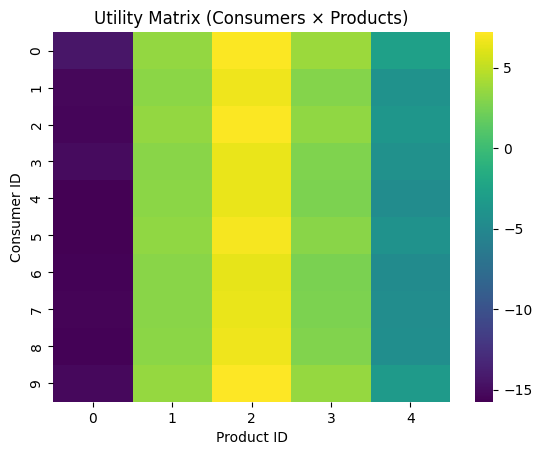

In [250]:
# Simulating consumers 
beta_record = []
alpha_record = []

shock_beta = np.random.normal(0,1, n_consumer)
shock_alpha = np.random.normal(0,1, n_consumer)
beta_i = beta + sigma_b*shock_beta
alpha_i = alpha + sigma_a*shock_alpha
beta_record.append(beta_i)
alpha_record.append(alpha_i)

# building the matrix (utilities of each product for a consumer)
market_0 = dataset[dataset['market_id'] == chosen_market].reset_index(drop=True)
x_j = market_0['x'].values  # shape (J,)
p_j = market_0['p'].values  # shape (J,)
U = np.outer(beta_record, x_j) - np.outer(alpha_record, p_j)

U_df = pd.DataFrame(U)
U_df.to_csv("simulated_utilities.csv", index=False)

print(U)

#optional: visualization to see product heterogeneity
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(U, cmap="viridis", cbar=True)
plt.title("Utility Matrix (Consumers × Products)")
plt.xlabel("Product ID")
plt.ylabel("Consumer ID")
plt.show()


## 🧪 Practice 5: Simulating Choice Probabilities and Market Shares

### 🎯 Goal
Use the utility matrix from Practice 4 to simulate:
1. Individual-level choice probabilities across products
2. Aggregate market shares by integrating over consumer heterogeneity

This step mimics the inner loop share prediction in the BLP model.

---

### 🧮 Theory

Each consumer chooses the product that gives the highest utility.  
Since utility has an unobserved Type I Extreme Value error, the **choice probability** for product $j$ by consumer $i$ is:

$$
P_{ij} = \frac{e^{u_{ij}}}{1 + \sum_k e^{u_{ik}}}
$$

The **denominator includes the outside good**, with normalized utility 0.

---

### 📊 Market Share Calculation

To get market-level share for each product, average over $R$ consumers:

$$
s_j = \frac{1}{R} \sum_{i=1}^R P_{ij}
$$

The **outside good share** is:

$$
s_0 = 1 - \sum_j s_j
$$

---

### ✅ Tasks

1. Use the utility matrix $U_{ij}$ to compute $P_{ij}$ for each consumer
2. Aggregate over consumers to get $s_j$ for each product
3. Compute $s_0$ as the share of the outside good
4. Optionally visualize shares or compare to prior logit shares

---

### 📌 Purpose

- This is the simulation that BLP uses in the inner loop
- You’ve now created a full demand prediction engine with heterogeneous consumers
- This prepares for inversion (Practice 6) and estimation (Practice 7)

In [245]:
# calculating choice prob (for each product) => market share 

# calculating for one market 

sum_utility = []

for i in range(10):
    temp = 0
    for j in range(5):
        temp += np.exp(U[i][j])
    sum_utility.append(temp)

prob_choice = U.copy()

prob_choice = np.exp(prob_choice)

for i in range(10):
    prob_choice[i] = prob_choice[i]/(sum_utility[i]+1)

# now we calculate predicted share by averaging over choice probabilities 
pred_share = np.zeros(5)

for i in range(10):
    for j in range(5):
        pred_share[j] += prob_choice[i][j]

pred_share = pred_share/10

share_0 = 1 - sum(pred_share)

print("product sample utilities", U[1])
print("predicted share of each", pred_share)
print("share of not buying", share_0)
print("actual share", dataset.share[dataset['market_id'] == chosen_market])

product sample utilities [-15.116   3.101   6.315   2.646  -4.407]
predicted share of each [ 0.     0.037  0.937  0.025  0.   ]
share of not buying 0.00172867745388
actual share 0    3.367844e-10
1    3.217973e-02
2    9.416063e-01
3    2.495032e-02
4    2.324841e-05
Name: share, dtype: float64
